In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

# __Appendix 3__ | Modeling

### __Load models__

In [2]:
%run utility/stan_utility.py # Utilities by Betancourt

#### Import data

In [3]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
names_2018 = ['streams', 'acousticness', 'danceability', 'loudness', 'tempo', 'valence']

global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
global_data_2018 = pd.read_csv('./data/2018_global_selected.csv',header=None, names=names)

#### Select top 30 

In [4]:
global_data = global_data[0:30]
global_data_2018 = global_data_2018[0:30]

#### Log transform the $Y$:

In [5]:
global_data['streams'] = np.log10(global_data['streams'])

#### Define method for calculating and combining LOO scores:

In [12]:
def extract_azfit(fit, prior_dict):
    azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                           observed_data='y', 
                           posterior_predictive='ypred', 
                           log_likelihood='log_lik')
    return azfit

In [13]:
def calculate_and_print_loo(fit, loos):
    prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
    
    azfit = extract_azfit(fit, prior_dict)
    loo_m = az.loo(azfit)
    loo_m['Model'] = model_name
    loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
    loos = loos.append(loo_m, sort=True)
    
    return loo_m.set_index('Model'), loos 

#### Fit all 8 models:

In [7]:
model_filenames = ['lin_3_uninformative.stan',
                   'lin_3_informative.stan',
                   'lin_5_informative.stan',
                   'lin_5_informative-interaction.stan',
                   'lin_5_informative-interaction2.stan',
                   'lin_5_informative-second_order.stan',
                   'lin_5_informative-second_order-inter.stan',
                   'lin_5_informative-third_order-inter.stan']

model_names = ['Linear; 3 Predictors Uninformative ',
               'Linear; 3 Predictors Weakly Informative, Normal ',
               'Linear; 5 Predictors Weakly Informative, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative inter 1, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative inter 2, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative squared, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative squared inter, Normal ',
               'Non-Linear; 5 Predictors Weakly Informative cubic, Normal ']

loos = pd.DataFrame(index=[], columns=["loo", "warning", "treedepth", "div"])
nums_b = [3,3,5,7,9,12,14,19]
fits = []

In [8]:
for filename, num_b, model_name in zip(model_filenames, nums_b, model_names):
    with open(filename, 'r') as file:
        
        gb_2017 = global_data.values
        gb_2018 = global_data_2018.values 
            
        data = dict(N=gb_2017.shape[0],
                    y=gb_2017[:,0],
                    X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
                    Npred=gb_2018.shape[0], 
                    X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
                    mu_a=0,
                    mu_b=np.zeros(num_b),
                    sigma_0=0.12*10)

        model = compile_model(filename, model_name=model_name) 
        fit = model.sampling(data=data, seed=2222)
        fits.append(fit)
        div_check, tree_check, energy_check = pystan.diagnostics.check_div(fit, verbose = 2), pystan.diagnostics.check_treedepth(fit, verbose = 2), pystan.diagnostics.check_energy(fit, verbose = 2)        
        p, loos = calculate_and_print_loo(fit,loos)
        

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d7d9746588bfa2a8625ed1ff2dda6b7 NOW.
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.0573821762909368) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9869628218271824) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.0736903822698456) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.0482494474189668) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior
/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_nu

### __Results__

#### __Results calculated with__ `az.loo` + HMC checks

First results are computed using Arviz's `loo` method and diagnostics using `pystan.diagnostics` 

In [9]:
loos_file = loos.set_index('Model')
loos_file

div energy        loo  \
Model                                                                         
Linear; 3 Predictors Uninformative                   True   True -46.902177   
Linear; 3 Predictors Weakly Informative, Normal      True   True -47.710106   
Linear; 5 Predictors Weakly Informative, Normal      True   True -44.447955   
Non-Linear; 5 Predictors Weakly Informative int...   True   True -47.073212   
Non-Linear; 5 Predictors Weakly Informative int...   True   True -53.656601   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -40.463160   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -45.214423   
Non-Linear; 5 Predictors Weakly Informative cub...  False   True -44.220867   

                                                       loo_se      p_loo  \
Model                                                                      
Linear; 3 Predictors Uninformative                  14.090307   7.378591   
Linear; 3 Predictors Weakly Informative, Normal     13.477069   6.907031   
Linear; 5 Predictors Weakly Informative, Normal     16.643005   9.582243   
Non-Linear; 5 Predictors Weakly Informative int...  12.337674   9.922506   
Non-Linear; 5 Predictors Weakly Informative int...   8.074899  10.787748   
Non-Linear; 5 Predictors Weakly Informative squ...  10.578317  13.491482   
Non-Linear; 5 Predictors Weakly Informative squ...   7.772988  14.734380   
Non-Linear; 5 Predictors Weakly Informative cub...   5.026211  19.015270   

                                                   treedepth warning  
Model                                                                 
Linear; 3 Predictors Uninformative                      True       1  
Linear; 3 Predictors Weakly Informative, Normal         True       1  
Linear; 5 Predictors Weakly Informative, Normal         True       1  
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1  
Non-Linear; 5 Predictors Weakly Informative cub...      True       1

#### __Sorted by `LOO`-column__

In [43]:
#loos_file = loos.set_index('Model')
loos_file.sort_values(by='loo')

div energy        loo  \
Model                                                                         
Non-Linear; 5 Predictors Weakly Informative int...   True   True -53.656601   
Linear; 3 Predictors Weakly Informative, Normal      True   True -47.710106   
Non-Linear; 5 Predictors Weakly Informative int...   True   True -47.073212   
Linear; 3 Predictors Uninformative                   True   True -46.902177   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -45.214423   
Linear; 5 Predictors Weakly Informative, Normal      True   True -44.447955   
Non-Linear; 5 Predictors Weakly Informative cub...  False   True -44.220867   
Non-Linear; 5 Predictors Weakly Informative squ...   True   True -40.463160   

                                                       loo_se      p_loo  \
Model                                                                      
Non-Linear; 5 Predictors Weakly Informative int...   8.074899  10.787748   
Linear; 3 Predictors Weakly Informative, Normal     13.477069   6.907031   
Non-Linear; 5 Predictors Weakly Informative int...  12.337674   9.922506   
Linear; 3 Predictors Uninformative                  14.090307   7.378591   
Non-Linear; 5 Predictors Weakly Informative squ...   7.772988  14.734380   
Linear; 5 Predictors Weakly Informative, Normal     16.643005   9.582243   
Non-Linear; 5 Predictors Weakly Informative cub...   5.026211  19.015270   
Non-Linear; 5 Predictors Weakly Informative squ...  10.578317  13.491482   

                                                   treedepth warning  
Model                                                                 
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Linear; 3 Predictors Weakly Informative, Normal         True       1  
Non-Linear; 5 Predictors Weakly Informative int...      True       1  
Linear; 3 Predictors Uninformative                      True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1  
Linear; 5 Predictors Weakly Informative, Normal         True       1  
Non-Linear; 5 Predictors Weakly Informative cub...      True       1  
Non-Linear; 5 Predictors Weakly Informative squ...      True       1

In [131]:
prior_dicts = [M.extract(pars=['a','b','sigma'], permuted=False) for M in fits]
azfits = [extract_azfit(M, prior_dicts[i]) for i,M in enumerate(fits)]

In [132]:
comparison = az.compare(dict(zip(model_names, azfits)), ic='loo')

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Est

#### __Results calculated with__ `az.compare`

In [21]:
comparison.to_csv('new_model_comparison.csv')
comparison

loo     ploo     dloo  \
Non-Linear; 5 Predictors Weakly Informative int... -53.6566  10.7877        0   
Linear; 3 Predictors Weakly Informative, Normal    -47.7101  6.90703  5.94649   
Non-Linear; 5 Predictors Weakly Informative int... -47.0732  9.92251  6.58339   
Linear; 3 Predictors Uninformative                 -46.9022  7.37859  6.75442   
Non-Linear; 5 Predictors Weakly Informative squ... -45.2144  14.7344  8.44218   
Linear; 5 Predictors Weakly Informative, Normal     -44.448  9.58224  9.20865   
Non-Linear; 5 Predictors Weakly Informative cub... -44.2209  19.0153  9.43573   
Non-Linear; 5 Predictors Weakly Informative squ... -40.4632  13.4915  13.1934   

                                                         weight       se  \
Non-Linear; 5 Predictors Weakly Informative int...     0.531883   8.0749   
Linear; 3 Predictors Weakly Informative, Normal        0.430785  13.4771   
Non-Linear; 5 Predictors Weakly Informative int...            0  12.3377   
Linear; 3 Predictors Uninformative                            0  14.0903   
Non-Linear; 5 Predictors Weakly Informative squ...  3.19671e-15  7.77299   
Linear; 5 Predictors Weakly Informative, Normal               0   16.643   
Non-Linear; 5 Predictors Weakly Informative cub...    0.0373315  5.02621   
Non-Linear; 5 Predictors Weakly Informative squ...            0  10.5783   

                                                        dse warning  
Non-Linear; 5 Predictors Weakly Informative int...        0       1  
Linear; 3 Predictors Weakly Informative, Normal     10.2594       1  
Non-Linear; 5 Predictors Weakly Informative int...  8.65384       1  
Linear; 3 Predictors Uninformative                  10.7492       1  
Non-Linear; 5 Predictors Weakly Informative squ...  3.56756       1  
Linear; 5 Predictors Weakly Informative, Normal     12.9033       1  
Non-Linear; 5 Predictors Weakly Informative cub...  6.85785       1  
Non-Linear; 5 Predictors Weakly Informative squ...  7.78216       1

#### __Posterior predictive checks__

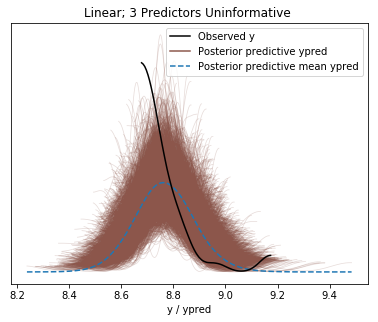

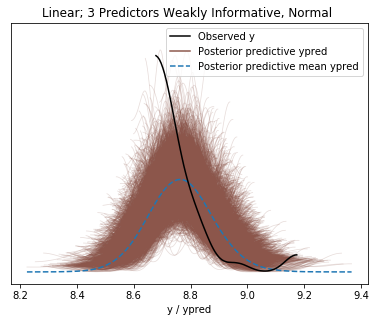

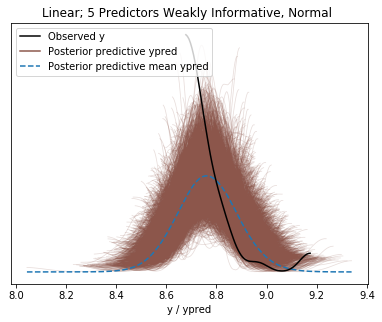

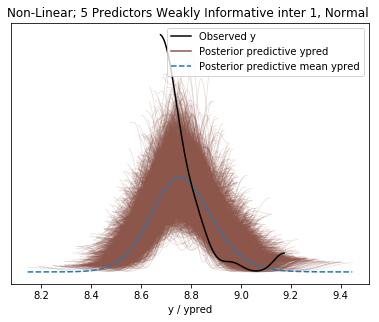

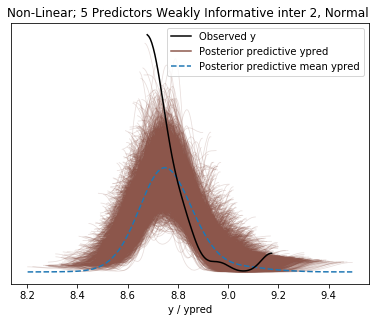

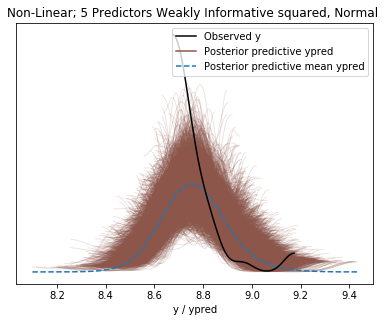

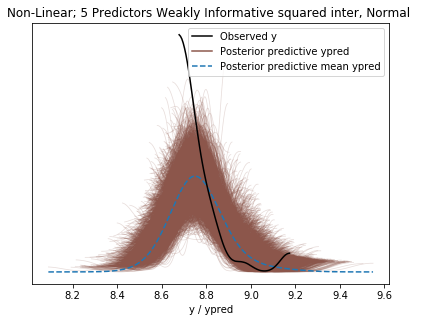

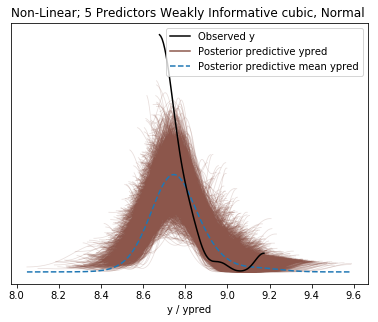

In [37]:
for M,name in zip(azfits,model_names):
    az.plot_ppc(M, data_pairs = {'y' : 'ypred'})
    plt.title(name)

### __Traces__

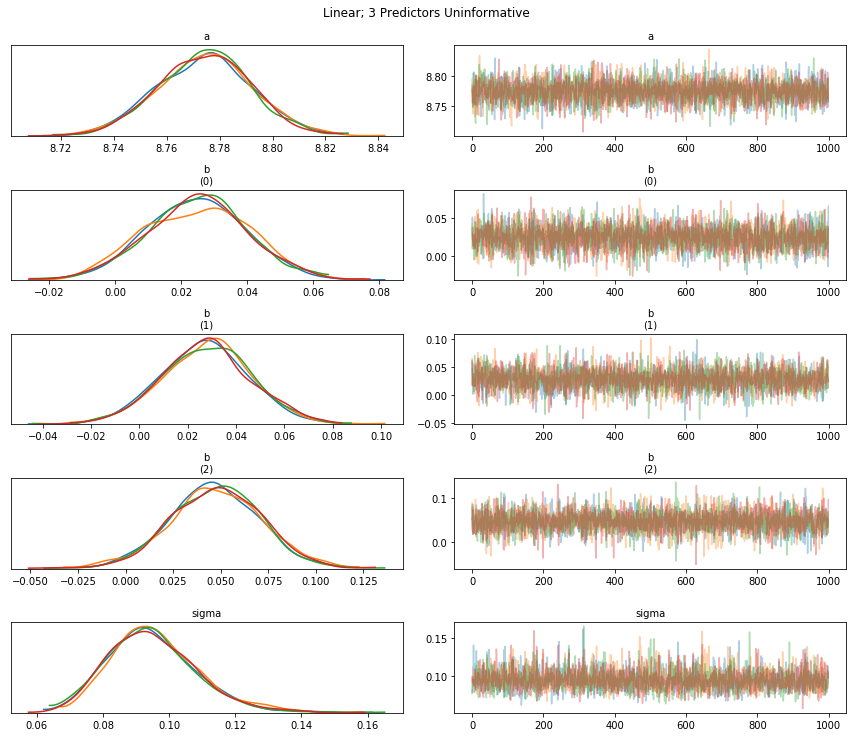

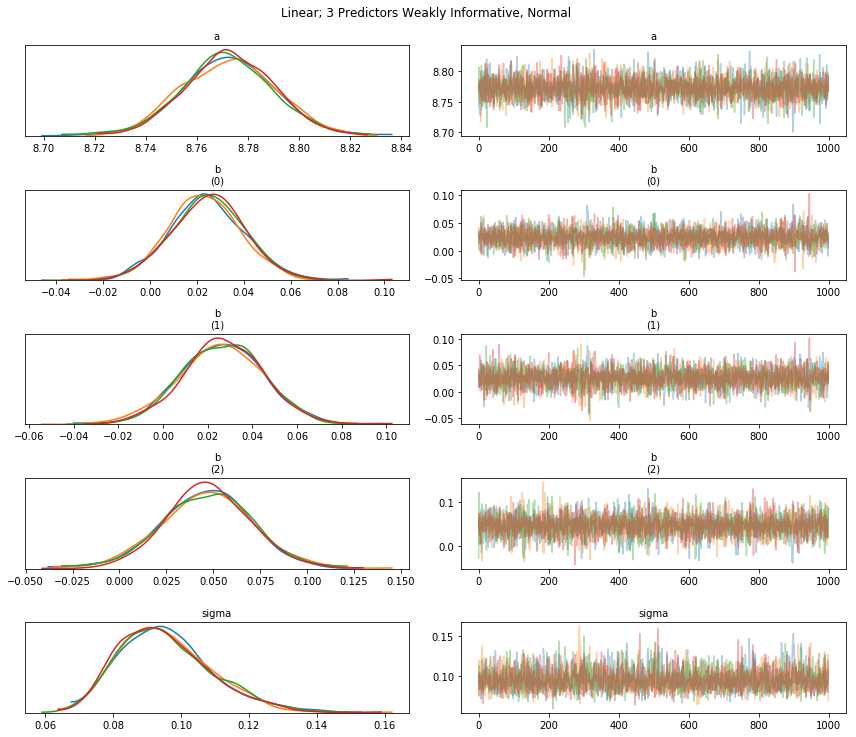

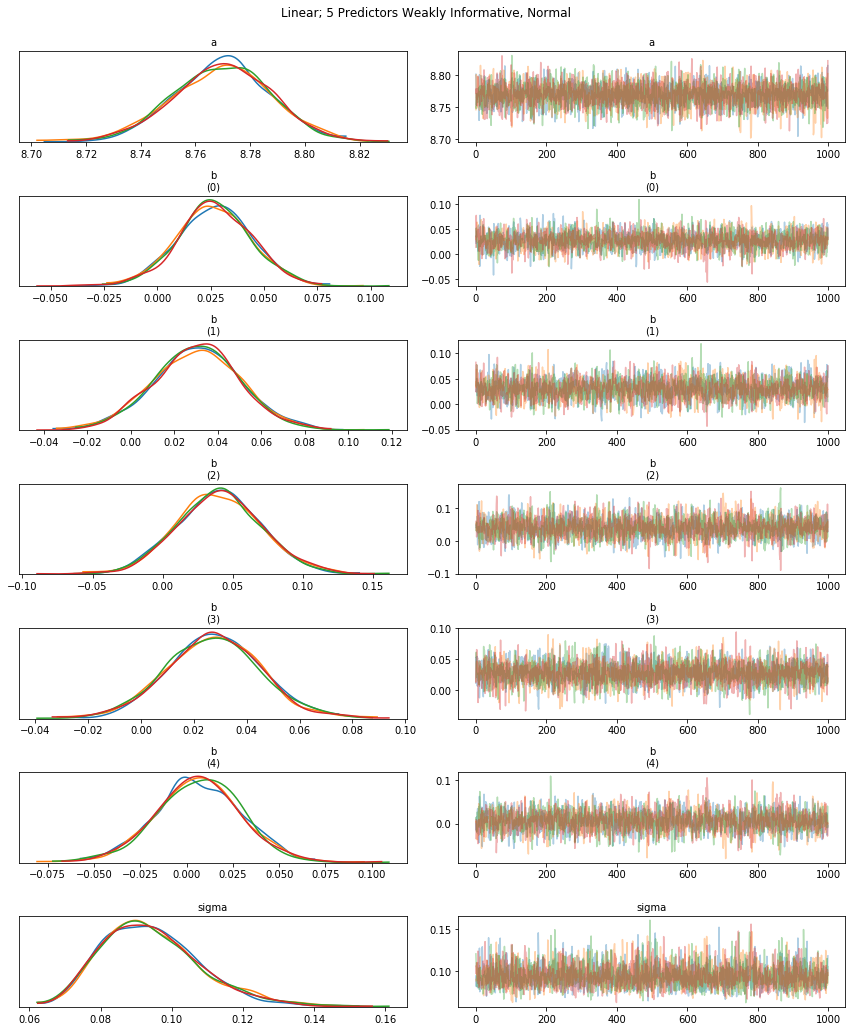

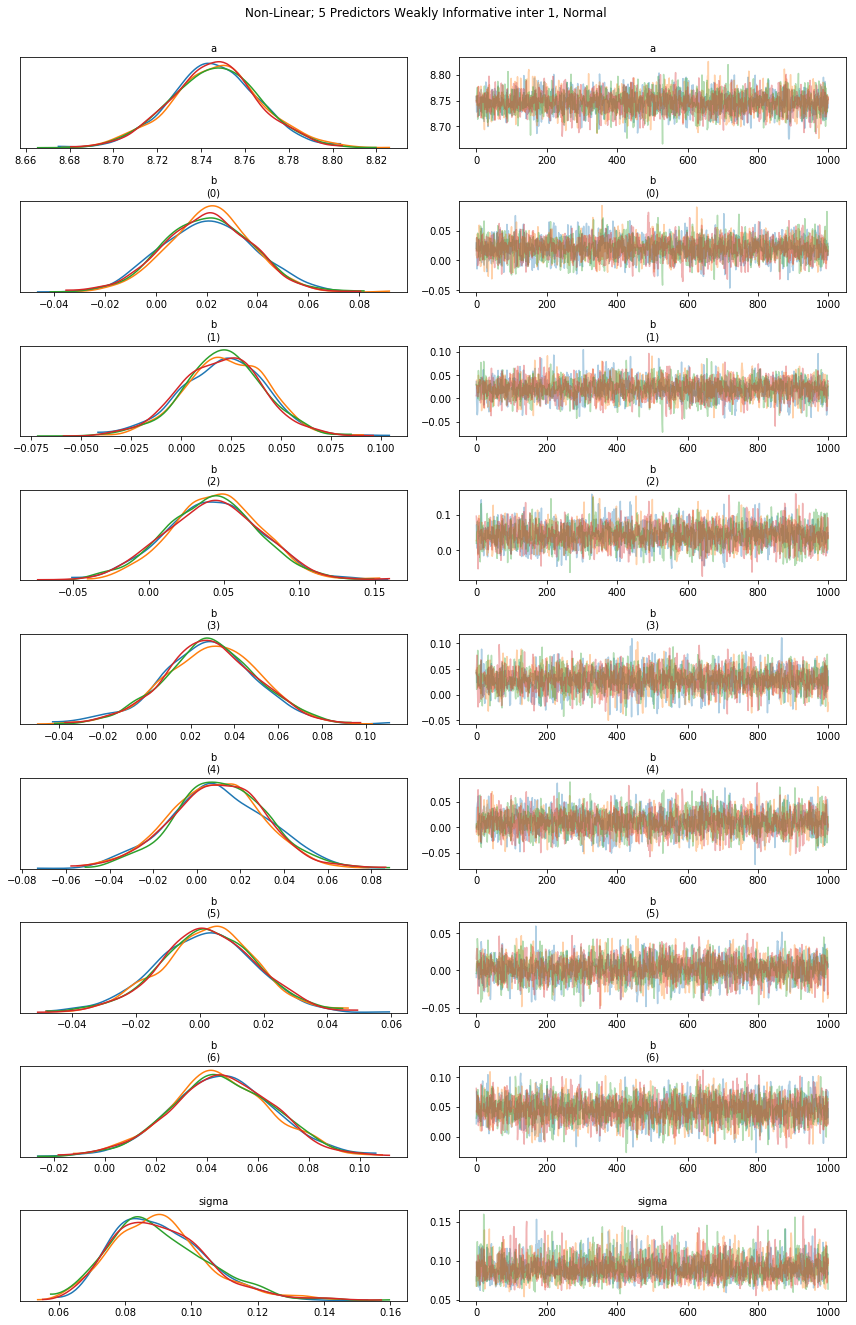

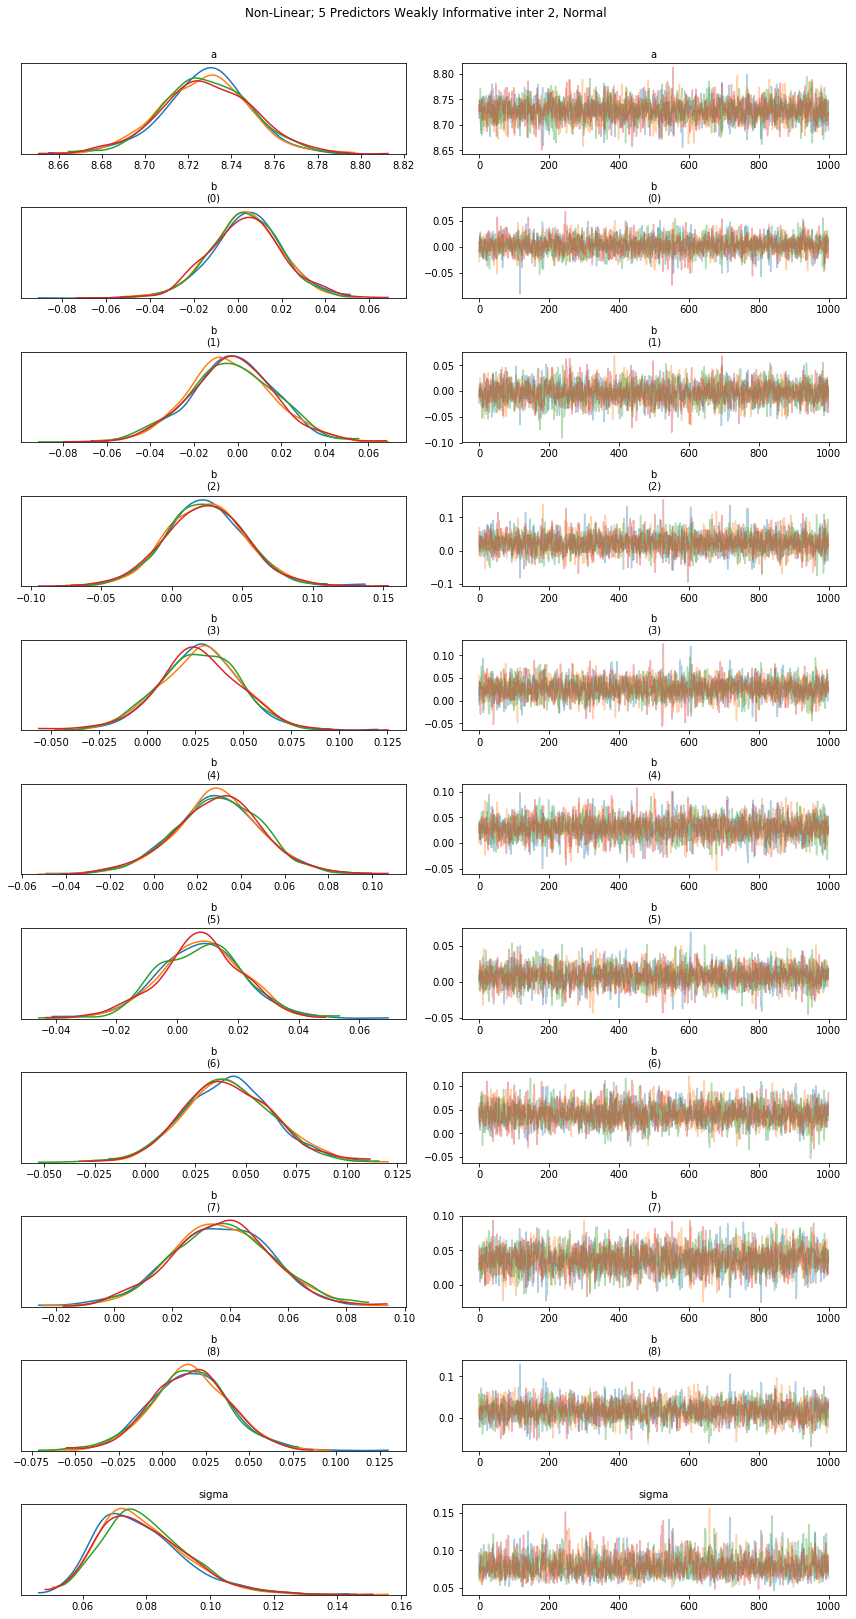

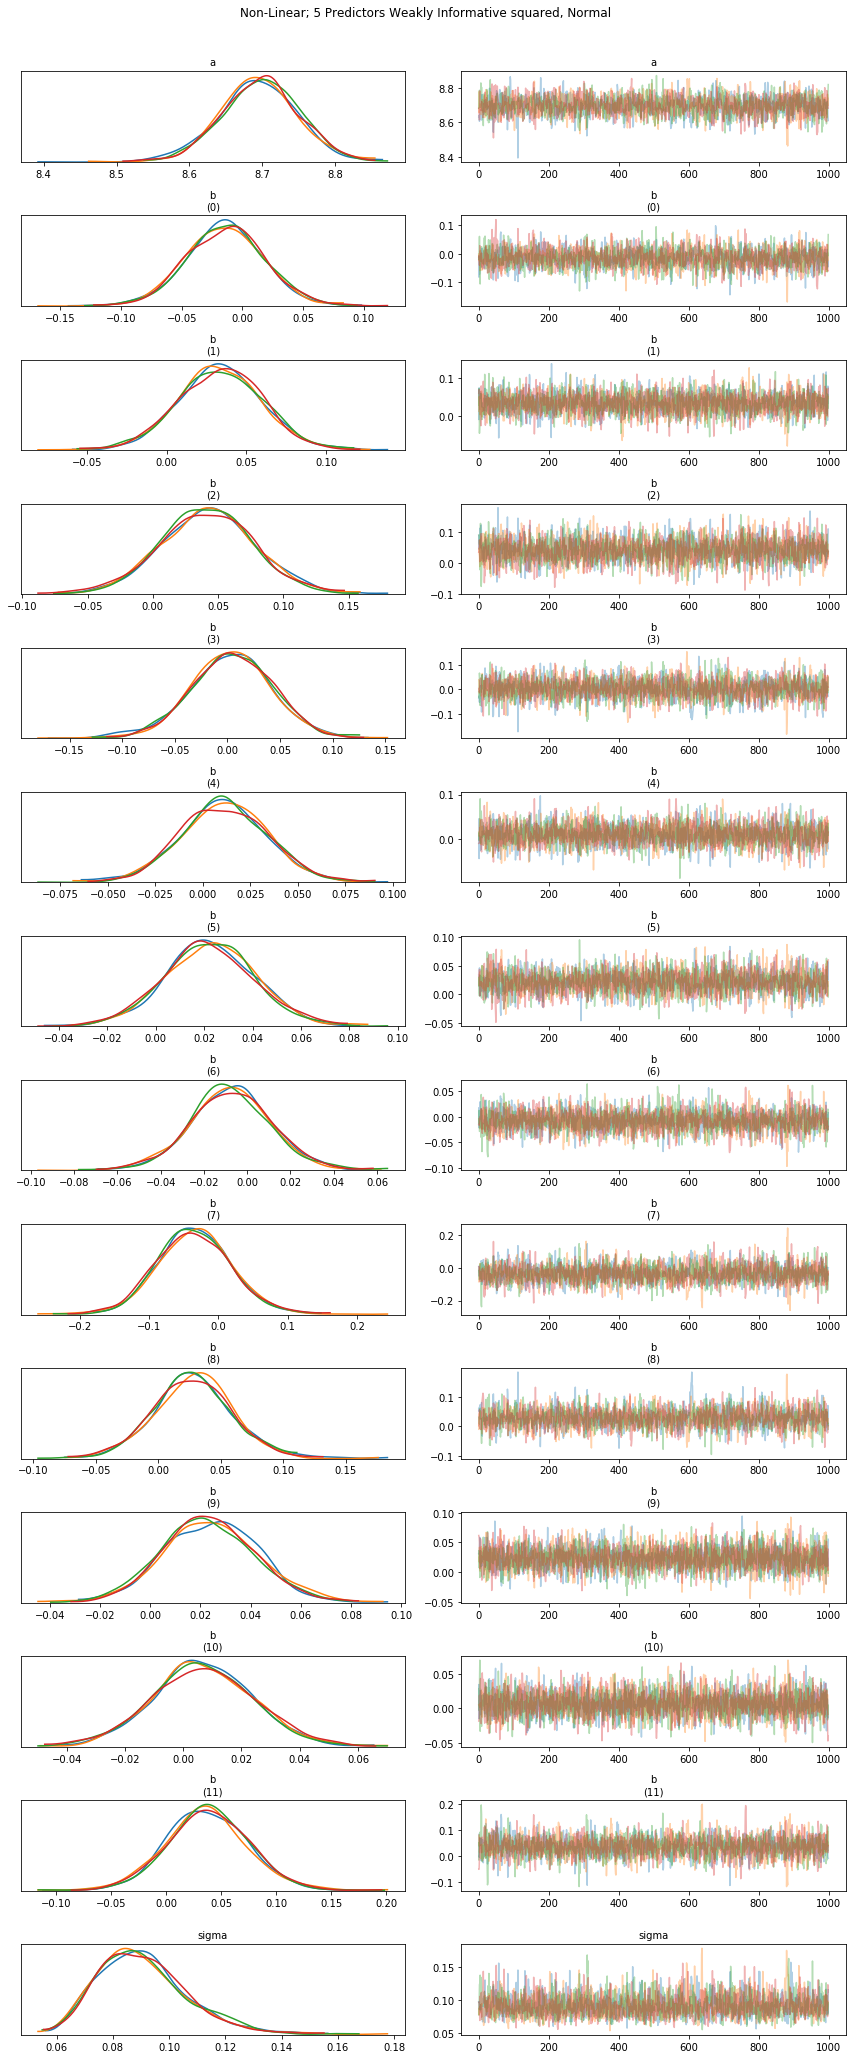

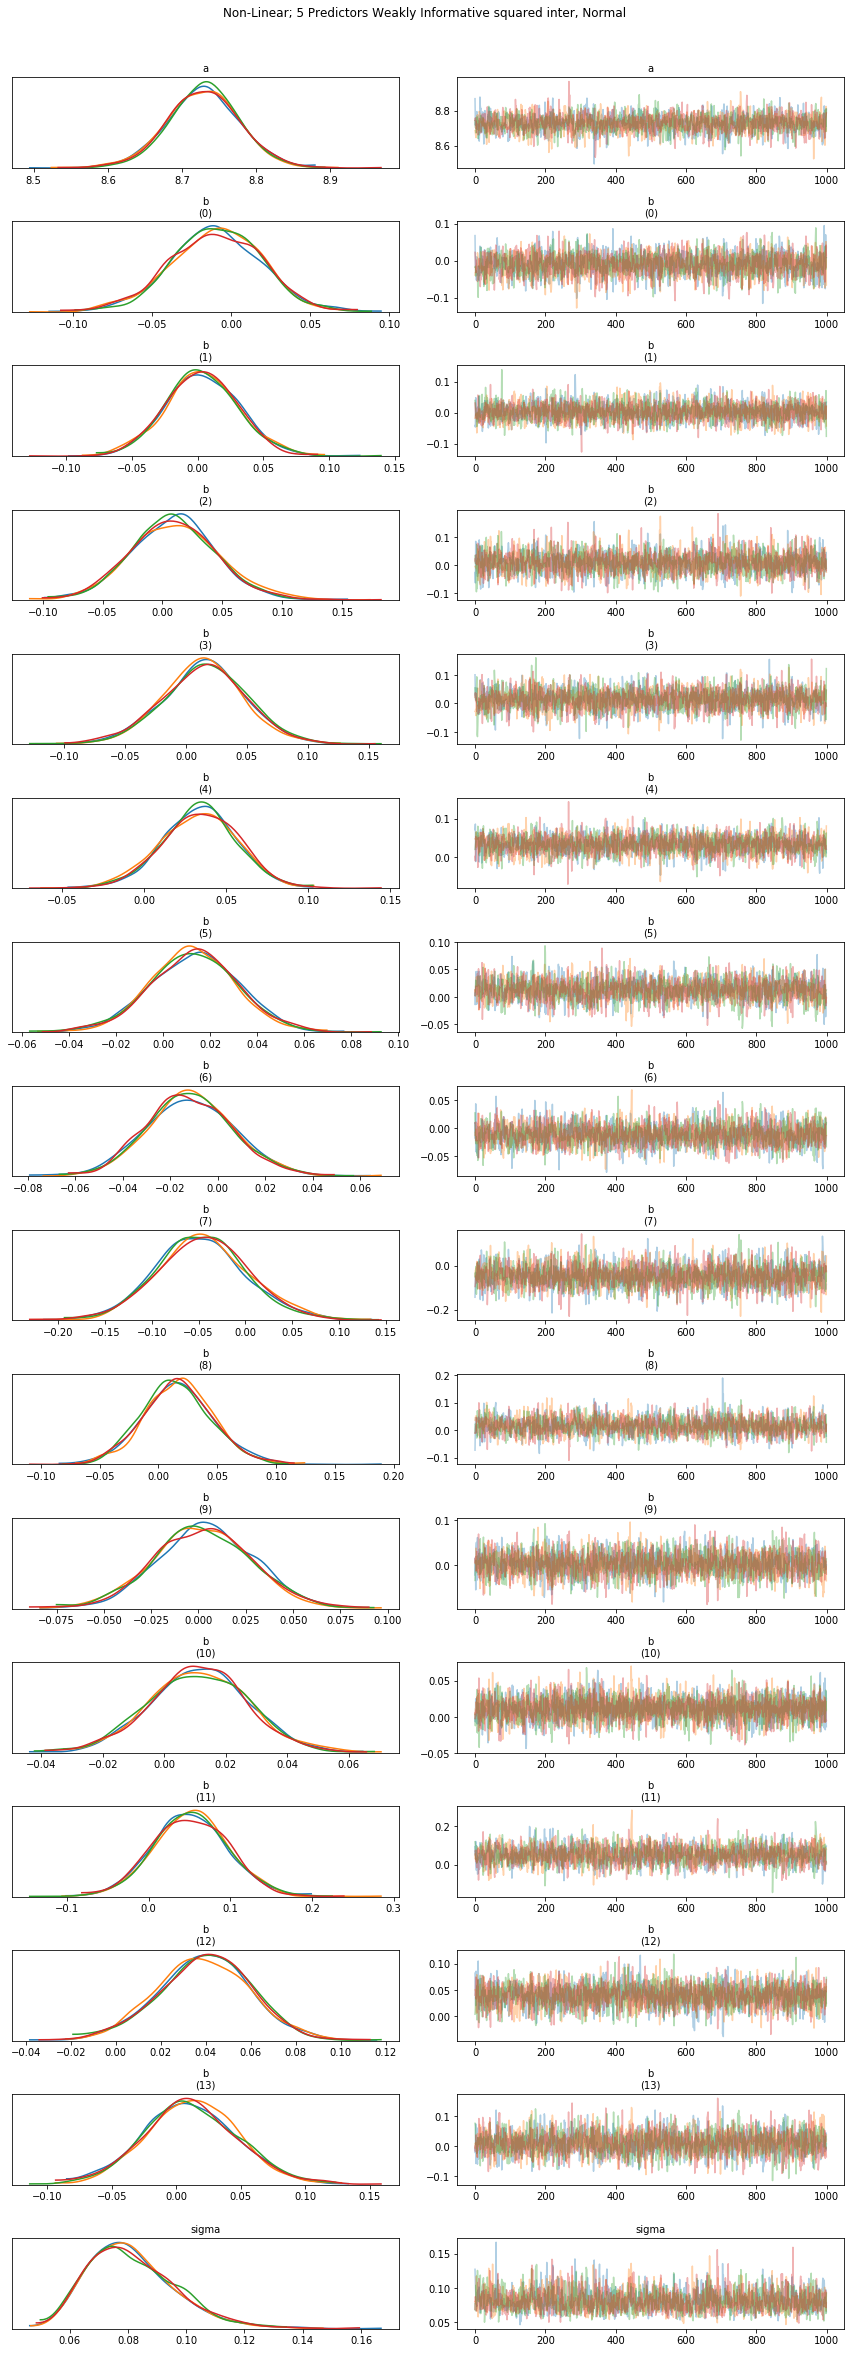

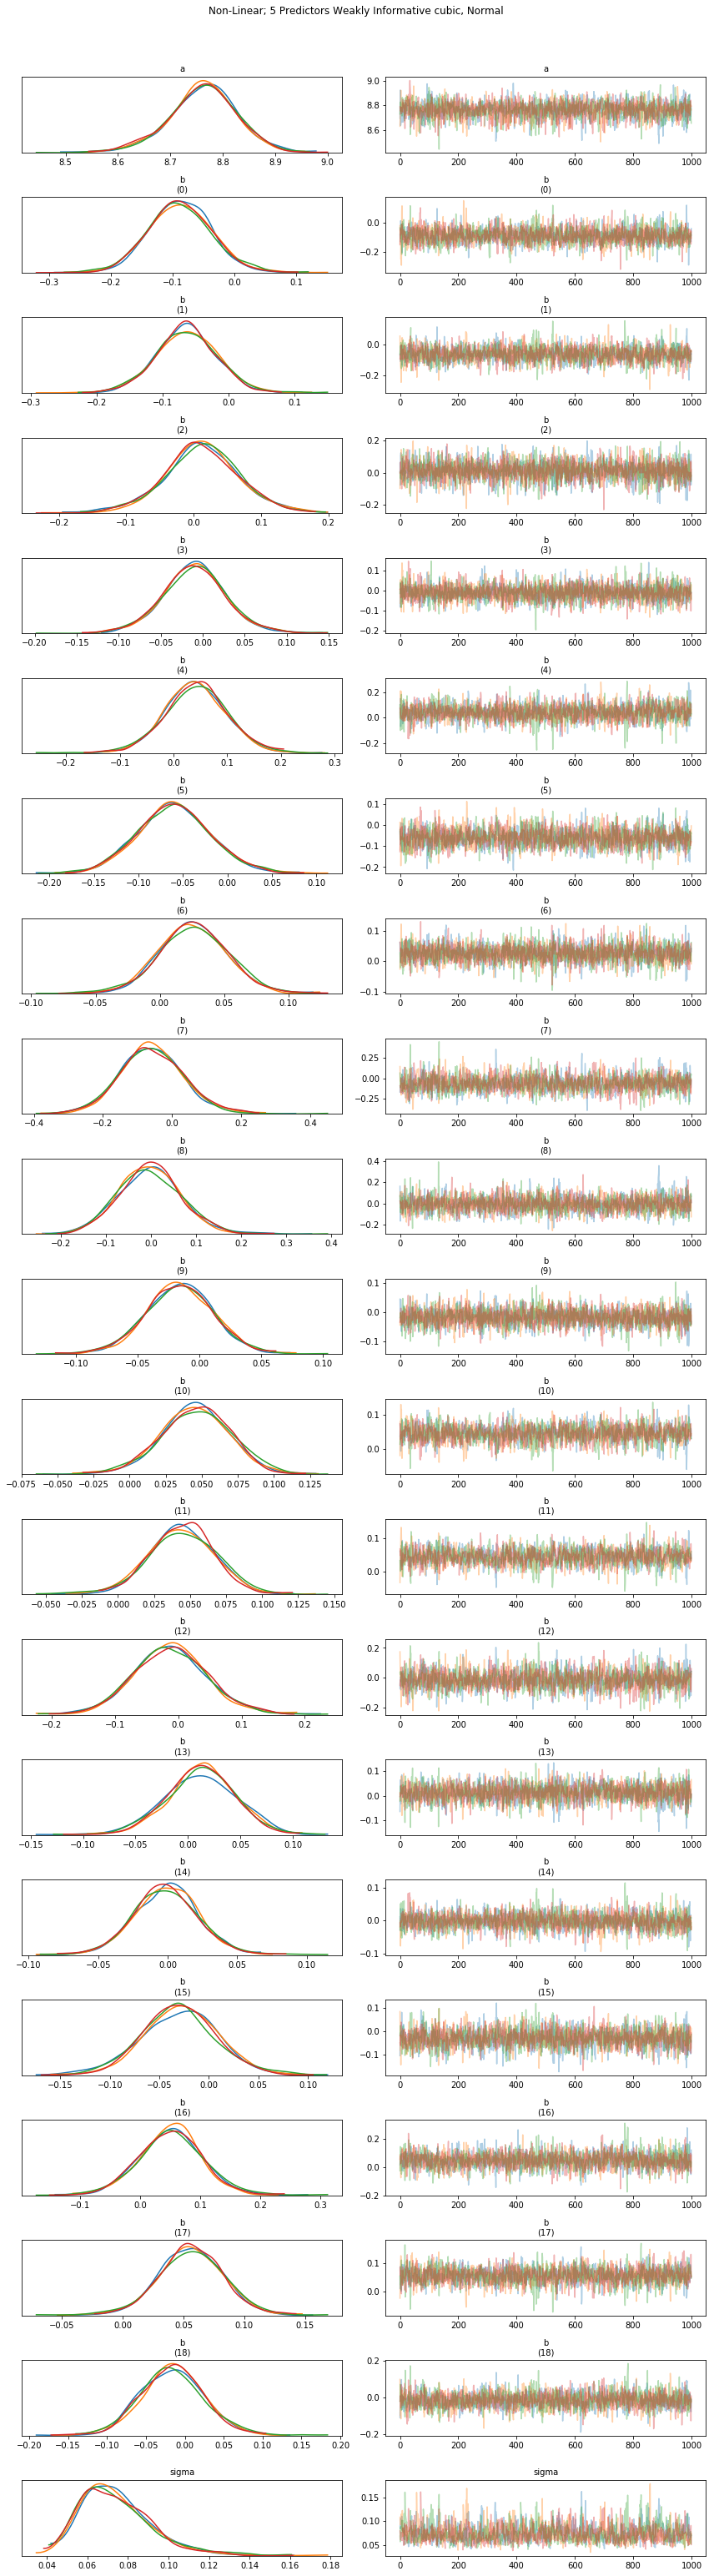

In [140]:
import time
for M, name in zip(azfits, model_names):
    azpos = M.posterior[['a','b','sigma']]
    az.plot_trace(azpos)
    plt.suptitle(name, y=1.02)
    time.sleep(0.02)


### __Pareto k values__

In [46]:
# Import PSIS from local directory, original code: https://github.com/avehtari/PSIS
%run PSIS/py/psis.py

In [104]:
def plot_ks(model_names, kss):
    legends = model_names
    N = len(fits) + 1
    plt.figure(figsize=(12,N*5))
    plt.suptitle('Pareto k values for the data', y=0.89)
    
    X = np.arange(0,31)
    Y = np.full(31, 0.7)
    plt.ylabel('k')
    plt.xlabel('Observation')
    for i,ks,lab in zip(range(1,N), kss, legends):
        ax = plt.subplot(N,1,i)
        #ax.set_ylim(0,1)
        ax.set_ylabel('Pareto k')
        ax.set_xlabel('Observation')
        ax.plot(X, Y, '--', alpha=.5, color='red')
        ax.plot(range(1,31), ks, 'o', label=lab, alpha=.6)
        ax.legend(loc='best')

In [105]:
kss = []
for M,name in zip(fits, model_names):
    loo, looss, ks = psisloo(M['log_lik'])
    kss.append(ks)

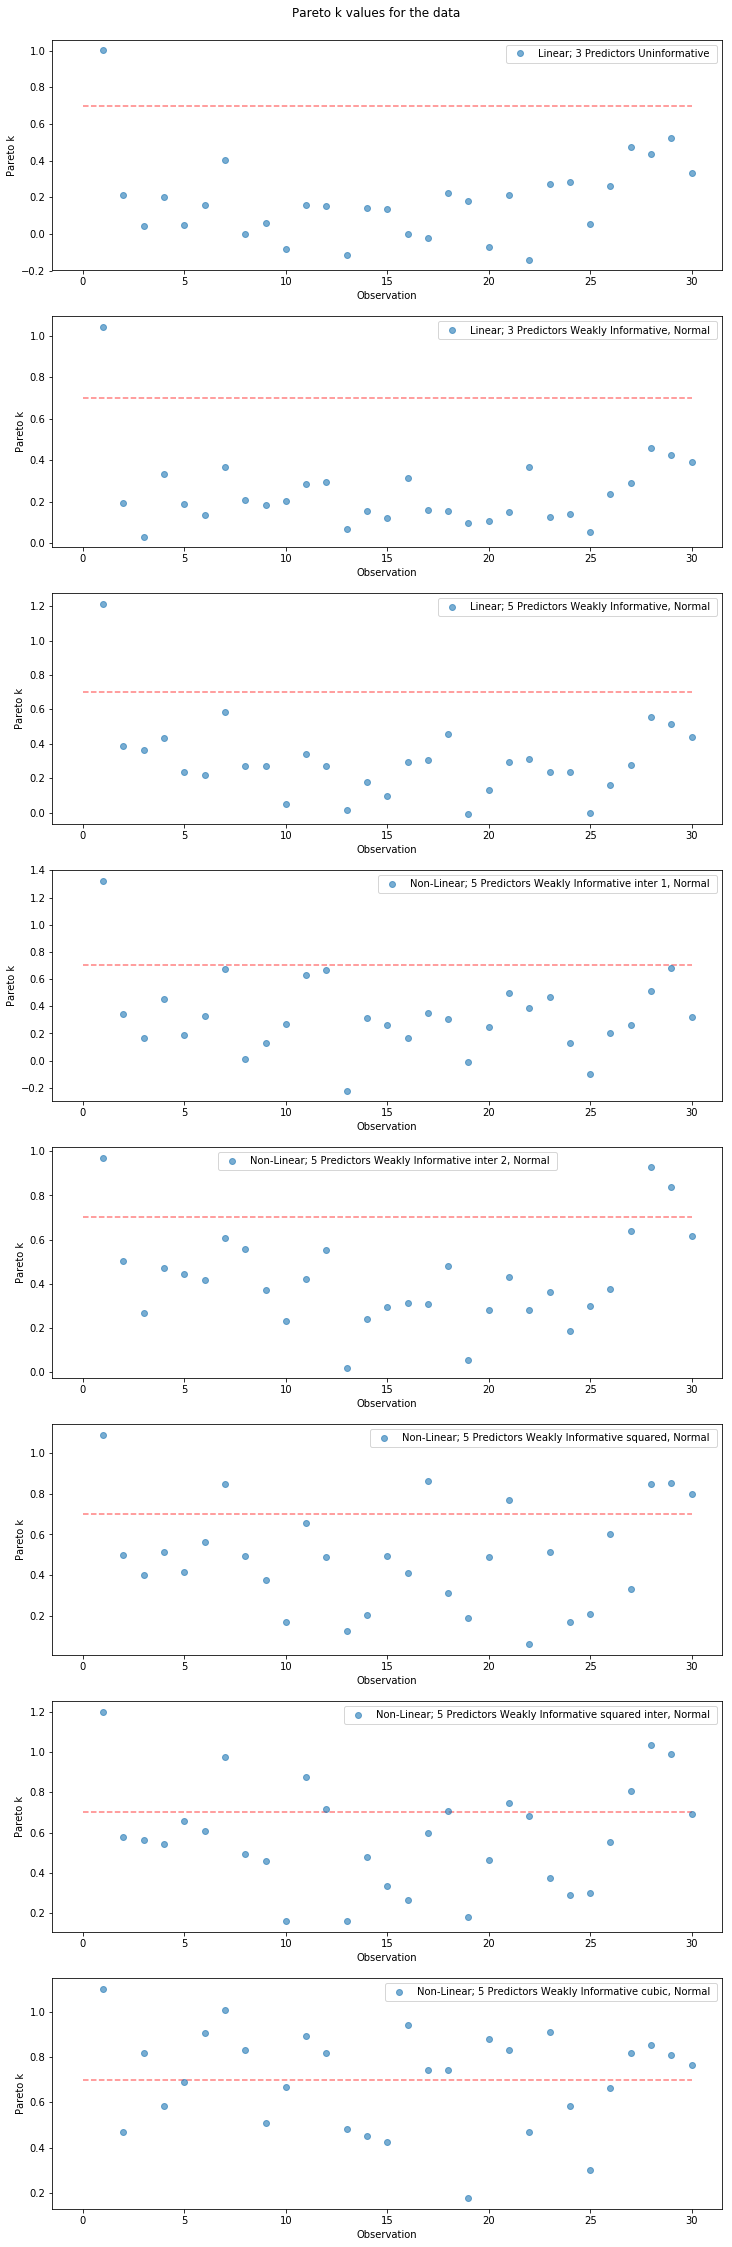

In [107]:
plot_ks(model_names, kss)

In [133]:
for name,ks in zip(model_names,kss):
    comparison.loc[name, 'k>0.7'] = np.sum(ks > 0.7)

In [134]:
comparison

loo     ploo     dloo  \
Non-Linear; 5 Predictors Weakly Informative int... -53.6566  10.7877        0   
Linear; 3 Predictors Weakly Informative, Normal    -47.7101  6.90703  5.94649   
Non-Linear; 5 Predictors Weakly Informative int... -47.0732  9.92251  6.58339   
Linear; 3 Predictors Uninformative                 -46.9022  7.37859  6.75442   
Non-Linear; 5 Predictors Weakly Informative squ... -45.2144  14.7344  8.44218   
Linear; 5 Predictors Weakly Informative, Normal     -44.448  9.58224  9.20865   
Non-Linear; 5 Predictors Weakly Informative cub... -44.2209  19.0153  9.43573   
Non-Linear; 5 Predictors Weakly Informative squ... -40.4632  13.4915  13.1934   

                                                         weight       se  \
Non-Linear; 5 Predictors Weakly Informative int...     0.531883   8.0749   
Linear; 3 Predictors Weakly Informative, Normal        0.430785  13.4771   
Non-Linear; 5 Predictors Weakly Informative int...            0  12.3377   
Linear; 3 Predictors Uninformative                            0  14.0903   
Non-Linear; 5 Predictors Weakly Informative squ...  3.19671e-15  7.77299   
Linear; 5 Predictors Weakly Informative, Normal               0   16.643   
Non-Linear; 5 Predictors Weakly Informative cub...    0.0373315  5.02621   
Non-Linear; 5 Predictors Weakly Informative squ...            0  10.5783   

                                                        dse warning  k>0.7  
Non-Linear; 5 Predictors Weakly Informative int...        0       1    3.0  
Linear; 3 Predictors Weakly Informative, Normal     10.2594       1    1.0  
Non-Linear; 5 Predictors Weakly Informative int...  8.65384       1    1.0  
Linear; 3 Predictors Uninformative                  10.7492       1    1.0  
Non-Linear; 5 Predictors Weakly Informative squ...  3.56756       1    9.0  
Linear; 5 Predictors Weakly Informative, Normal     12.9033       1    1.0  
Non-Linear; 5 Predictors Weakly Informative cub...  6.85785       1   17.0  
Non-Linear; 5 Predictors Weakly Informative squ...  7.78216       1    7.0

### __Conclusion__
Best performance is given by 5 predictor model with interaction terms. However there are 3 pareto k values over the 0.7 treshold. Thus the LOO and $p_{LOO}$ values can't be considered reliable. The second and the third model in the list are performing well with only the top song breaching the $k>0.7$ limit. Simpler models seem to outperform the more complex non-linear models. 